# Uncertainties and Relationships in Complex Models

We have a complex box-model with six inputs and 22 outputs. Each input has an uncertainty associated with it. To calculate the uncertainties associated with the outputs, we use a Monte-Carlo approach. 

The model is run 100,000 times. In each iteration, all six input parameters are varied within their uncertainty (mean +/- 2 s.d., normal distribution).

There are multiple model runs representing different time periods. Some of the input parameters (and their uncertainties) are defined by time.

Each model output is a text file containing 28 columns and 100000 rows of tab-separated numbers. The first six columns are the input parameters, the remaining 22 are the model outputs.

**NOTE**: Because of file size limitations, only 5000 data points from each Monte-Carlo run are provided.

### Questions:

1. What is the uncertainty associated with each output parameter?
2. How to work out which parameters have most affect on the outputs?

In [1]:
import zipfile, os, re
import numpy as np
import pandas as pd
from tqdm import tqdm  # progress bars

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.dpi'] = 120

## Read Data

In [2]:
# check whether the data are uncompressed
if not os.path.exists('ModelData/'):
    # if not, uncompress it.
    cdata = zipfile.ZipFile('ModelData.zip')
    cdata.extractall('./')

In [3]:
# column names
inputs = ['i00','i01','i02','i03','i04','i05']
outputs = ['o00','o01','o02','o03','o04','o05','o06',
           'o07','o08','o09','o10','o11','o12','o13',
           'o14','o15','o16','o17','o18','o19','o20',
           'o21']

cols = inputs + outputs

In [4]:
# read data
dat = pd.read_table('ModelData/58cm.txt', sep='\s+', header=None)
dat.columns = cols

In [5]:
# check shape is as expected
dat.shape

(5000, 28)

In [6]:
# check if data looks right
dat.head()

,i00,i01,i02,i03,i04,i05,o00,o01,o02,o03,...,o12,o13,o14,o15,o16,o17,o18,o19,o20,o21
0,5.513469,22.542214,16.375471,27.948968,1.134050e+12,-9.221467,37.032760,37.895427,37.624753,37.769966,...,1.395776,0.969037,36.154054,0.950379,31.339841,59.710687,8.732933e+11,1.568549e+12,1.347658e+12,91.050528
1,8.564659,22.761417,14.423597,27.328296,9.999169e+11,-10.164063,37.614166,38.061156,37.755283,37.916002,...,1.650937,1.307719,36.128628,0.922918,28.851489,68.004597,1.024173e+12,1.521369e+12,1.440711e+12,96.856086
2,3.546380,23.892493,18.753798,28.859740,8.640674e+11,-9.967286,38.492943,38.427891,38.106705,38.313568,...,0.714762,0.362571,36.170447,0.968083,30.291214,73.597780,1.400406e+12,1.849608e+12,1.523907e+12,103.888990
3,5.686242,23.733772,18.243887,26.500796,9.809068e+11,-10.099581,37.463987,38.006094,37.722967,37.890512,...,0.829963,0.512122,36.152615,0.948824,31.191693,65.656657,1.068848e+12,1.677187e+12,1.423724e+12,96.848350
4,6.034157,23.952596,15.686177,28.549757,9.885885e+11,-10.234018,38.294067,38.403793,38.031375,38.232365,...,1.972363,1.236332,36.149715,0.945693,29.870851,74.497722,1.368435e+12,1.731893e+12,1.748829e+12,104.368570


# Question 1: Estimating Uncertainty of Outputs

The Monte-Carlo approach is specifically designed for this. As long as there are sufficient iterations (100,000 is plenty!), the distributions of each distribution will reflect its incertainty *as a function of the uncertainty of the inputs*.

As long as the parameter of interested is normally distributed, the parameter can be represented as the mean, and the uncertainty as the standard deviation of the value of the parameter produced by all iterations of the model.

If the parameter is not normally distributed, you might want to use the median and [1-sigma (68%)](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) confidence interval, instead.

In this case, they are the same because the output is normally distributed.

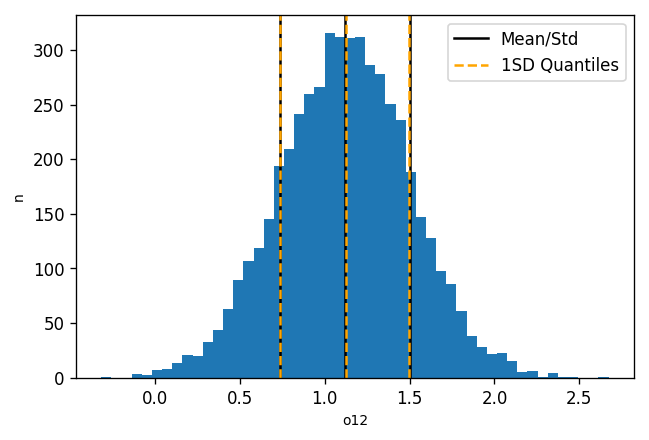

In [7]:
v = 'o12'  # the output parameter to plot
x = dat.loc[:, v]

plt.hist(x, 50)

# draw mean and stdev
plt.axvline(x.mean(), c='k', label='Mean/Std')
plt.axvline(x.mean() - x.std(), c='k')
plt.axvline(x.mean() + x.std(), c='k')

# draw median and 1-sigma quantiles
i = 0
for pc in np.percentile(x, [16, 50, 84]):
    if i == 0:
        plt.axvline(pc, c='orange', ls='dashed', label='1SD Quantiles')
        i += 1
    else:
        plt.axvline(pc, c='orange', ls='dashed')

plt.legend()
plt.xlabel(v)
plt.ylabel('n')

## Repeat for each time slice

Because we have multiple models calculated with different inputs at different time points, we must repeat this separately for each time slice.

In [8]:
import os
import re

In [9]:
# get list of data files
fs = os.listdir('ModelData/')
fs = [f for f in fs if '.txt' in f]

#  regular expression (RegEx) for extracting the depth info from the file name
dex = re.compile('[0-9]+')

In [10]:
uncs = pd.DataFrame(columns=['mean', 'sd'], dtype=float)

v = 'o12'

for f in tqdm(fs):
    d = float(dex.match(f).group())
    
    # read data
    dat = pd.read_table('ModelData/' + f, sep='\s+', header=None)
    dat.columns = cols

    uncs.loc[d, ['mean', 'sd']] = dat.loc[:,v].mean(), dat.loc[:,v].std()

uncs.sort_index(inplace=True)

100%|██████████| 5/5 [00:00<00:00, 29.15it/s]


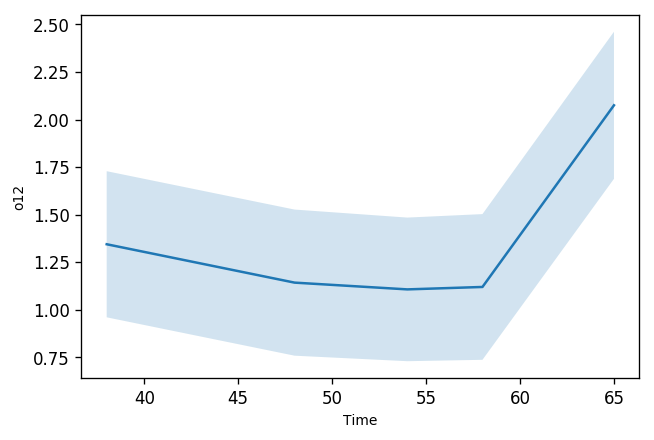

In [11]:
plt.plot(uncs.index, uncs.loc[:,'mean'])
plt.fill_between(x=uncs.index,
                 y1=uncs.loc[:,'mean'] - uncs.loc[:,'sd'],
                 y2=uncs.loc[:,'mean'] + uncs.loc[:,'sd'],
                 alpha=0.2, zorder=-1)
plt.ylabel(v)
plt.xlabel('Time')

# Question 2: How are output parameters related to input parameters?

In datasets like this, with multiple intputs/outputs, this is not easy. The fundamental is, how do you find where the relationships are in multi-parameter space, *when you don't know the form of these relationships*?

If you're expecting all relationships to follow a pre-defined relationship (e.g. linear, cubic, or *any function*), you could look at the R2, to determine how close the data are to the expected relationship.

If you're expecting relationships to be monotonic (i.e. change in only one direction, with no inflection points), then you could use a [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient), which gives you the strength of a monotonic relationship, regardless of functional form.

However, with complex models where the functional form of the relationships is unknown (e.g. could be linear, high degree polynomial, sinusoidal, circular, etc. etc.), these simple approaches fall apart. For data like this were you need to be able to identify the strength of relationships with *unknown form*, we need [Information Theory](https://en.wikipedia.org/wiki/Information_theory).

We're going to explore an approach that uses the [Maximal Information Coefficient](http://science.sciencemag.org/content/334/6062/1518.full), which was developed in 2011 for identifying new relationships in big, complicated datasets.

### Take a subset of the data, for speed

In [12]:
# read data
dat = pd.read_table('ModelData/58cm.txt', sep='\s+', header=None)
dat.columns = cols

# If we work with all 100,000 samples, everything'll take ages to run.
# For initial playing around, we'll take a subset to speed things up.

odat = dat.copy()  # make copy of original dataset
dat = odat.sample(1000)  # redefine `dat` as a subset of dataset

# Note: by doing it like this, you can just remove this bit later
# to run everything below with the entire dataset. Takes longer,
# but will be more 'correct'.

### Crossplot Everything

With only 28 parameters, this is (just) feasible. However, it doesn't provide any quantitative information on how well the parameters are related.

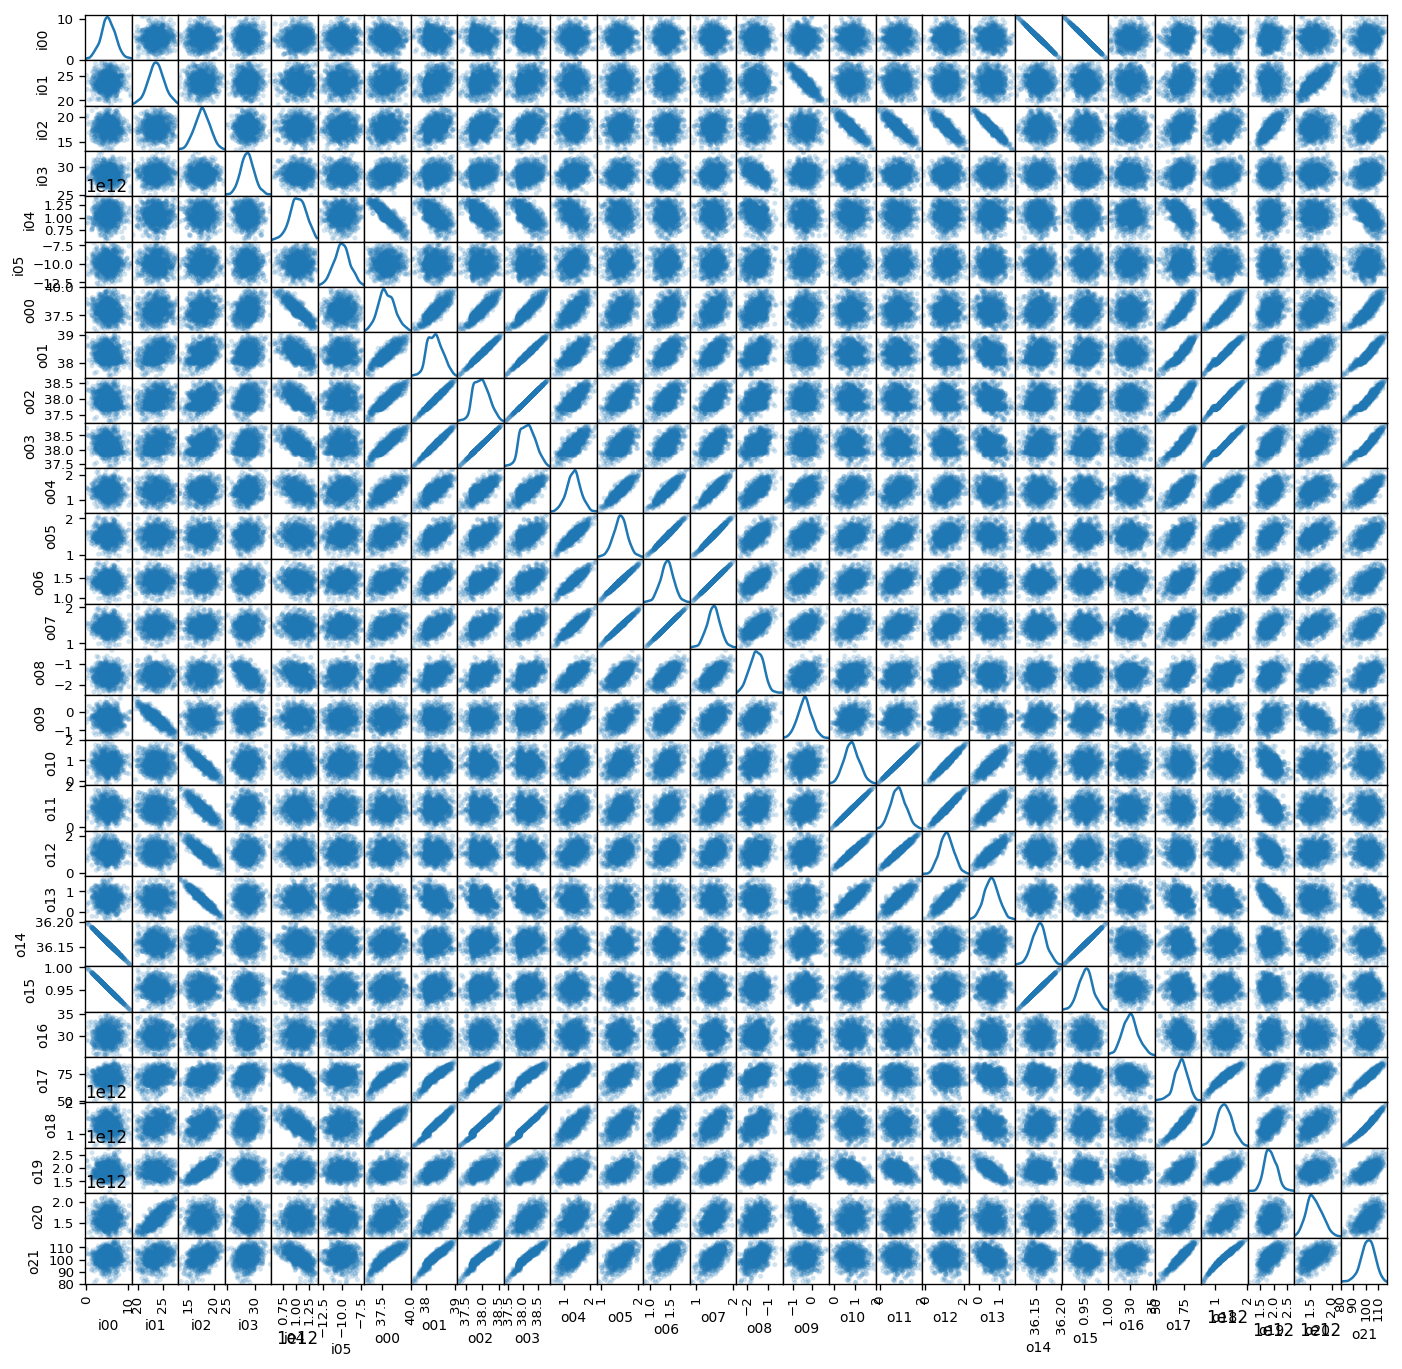

In [13]:
fig = pd.plotting.scatter_matrix(dat, alpha=0.2, diagonal='kde', figsize=[14,14])

plt.savefig('crossplot.png', dpi=200)

In this dataset, pretty much all the relationships are linear (or near-linear). This means that we *could* have used the Spearman's coefficient to estimate the strengths of correlations.

However, what if you had too many parameters to plot? Or non-monotonic relationships? To make this as generally applicable as possible, we'll use an approach that doesn't care about the shapes of the relationships: MIC.

## Maximal Information Coefficient (MIC) with MINE

The people who invented [MIC](http://science.sciencemag.org/content/334/6062/1518.full) have helpfully written a Python package called [minepy](http://minepy.readthedocs.io/en/latest/). We'll use it.

In [14]:
import minepy as mp

In [15]:
# a few 'helper functions'
def print_mic(mine):
    """Print the MIC"""
    print ("MIC", mine.mic())
    
def scatterplot(xv, yv):
    """Scatterplot of the variables xv and xv."""
    x = dat.loc[:, xv].values
    y = dat.loc[:, yv].values
    
    plt.scatter(x, y, s=5, alpha=0.1, c='k')
    plt.xlabel(xv)
    plt.ylabel(yv)

def micplot(xvars, mics, yv):
    """Plot the MIC for yv as a function of xvars"""
    fig, ax = plt.subplots(1,1)
    xn = np.arange(len(xvars))

    ax.scatter(xn, mics)
    ax.set_xticks(xn)
    ax.set_xticklabels(xvars, rotation=90)

    ax.set_ylabel('MIC cv. ' + yv)
    ax.set_xlabel('Param')

### Example: compare two arbitrary parameters with MIC

In [16]:
# set up 'miner' object
miner = mp.MINE(alpha=0.6, c=20)

**IMPORTANT**: you'll notice two parameters here (`alpha` and `c`), which alter how the MIC is calculated. Their explanation is outside our scope. If you're going to use this for anything, you need to understand what these do. A good place to start with this is the [Python documentation](http://minepy.readthedocs.io/en/latest/python.html#minepy.MINE), and then refer to the [paper](http://science.sciencemag.org/content/334/6062/1518.full) to make sure you understand what they're doing.

In [17]:
# isolate x, y variables
xv = 'i02'
yv = 'o12'

# change xv and yv to examine the relationships between
# different parameters.

x = dat.loc[:, xv].values
y = dat.loc[:, yv].values

In [18]:
miner.compute_score(x, y)

MIC 0.6068351896705246


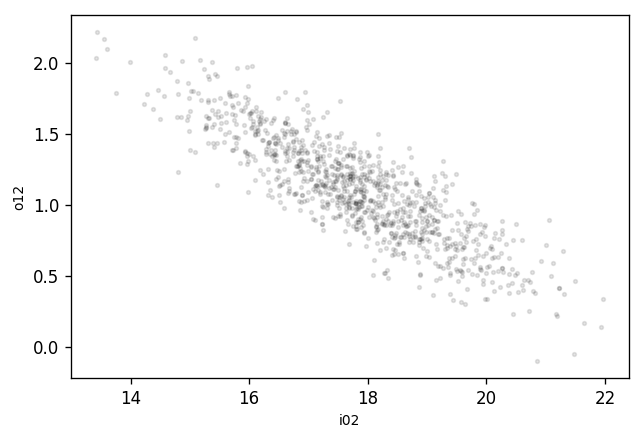

In [19]:
# visualise data
scatterplot(xv, yv)

print_mic(miner)

## Using MIC

### Approach 1: Test MIC of all outputs for specific input

You could use this to work out relationships between outputs and a particular input.

In [20]:
# do this for all outputs!
omics = []

inp = 'i01'
x = dat.loc[:, inp].values

for o in tqdm(outputs):
    y = dat.loc[:, o].values
    
    miner.compute_score(x, y)
    omics.append(miner.mic())

100%|██████████| 22/22 [00:07<00:00,  2.86it/s]


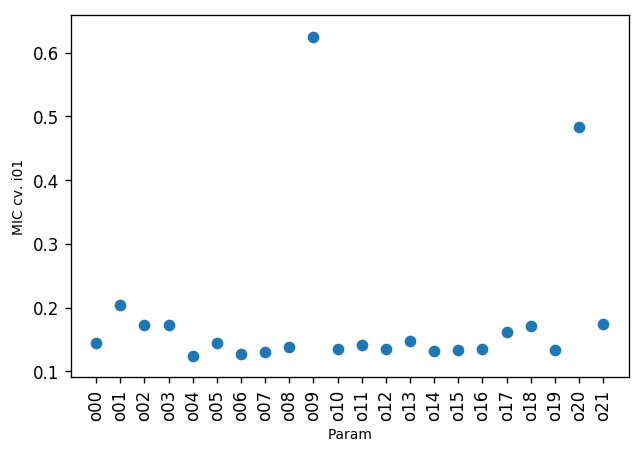

In [21]:
micplot(outputs, omics, inp)

This reveals a particularly strong relationship between input `i01` and output `o09`, which could be investigated further...

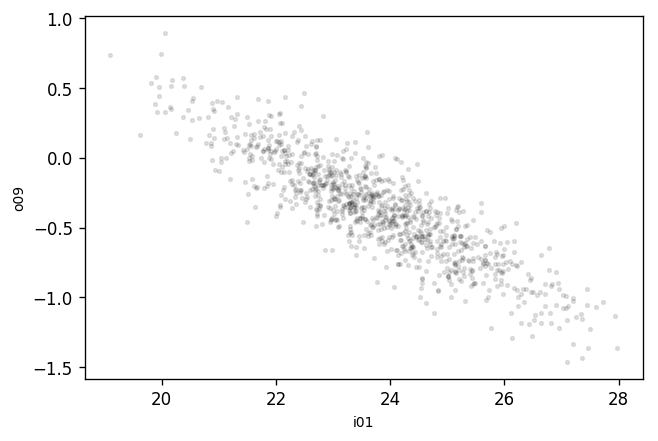

In [22]:
scatterplot(inp, 'o09')

### Approach 2: Test MIC of all inputs relative to a specific output

Use this to work out which input is most tightly correlated with a particular output parameters.

In [23]:
imics = []

outvar = 'o08'
y = dat.loc[:, outvar].values

for i in tqdm(inputs):
    x = dat.loc[:, i].values
    
    miner.compute_score(x, y)
    imics.append(miner.mic())

100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


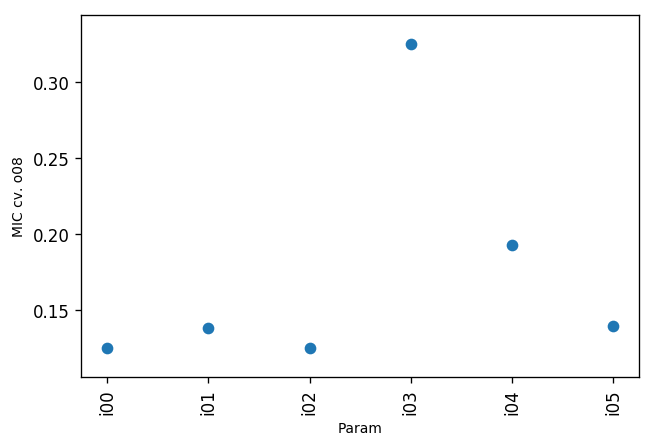

In [24]:
micplot(inputs, imics, outvar)

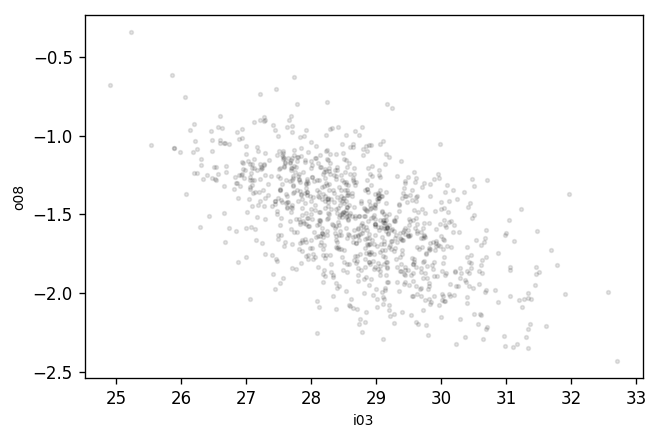

In [25]:
scatterplot('i03', outvar)

## Or... EVERYTHING VS EVERYTHING

A 'brute force' approach. This is similar to the scatterplot above, except you now have a MIC number associated with each pair of variables. This allows you to identify potentially interesting relationships within your data, without having to look at it all.

In [26]:
# note - this might take a minute or two to run...
miner = mp.MINE(alpha=0.6, c=20)

mics = np.zeros((dat.shape[1], dat.shape[1]))

# get the triangular indices of 28 (google numpy triu_indices)
# this saves us runing duplicate parameter combinations, by only
# considering symmetrically unique pairs.

inds = np.triu_indices(dat.shape[1])  
for i, j in tqdm(zip(*inds), total=len(inds[0])):
    ic = dat.columns[i]
    jc = dat.columns[j]
    
    x = dat.loc[:, ic]
    y = dat.loc[:, jc]
    
    miner.compute_score(x, y)
    mics[i, j] = miner.mic()
    mics[j, i] = miner.mic()


100%|██████████| 406/406 [02:02<00:00,  3.31it/s]


In [27]:
# Parameter pairs with VERY high MICs are likely defined as a 
# function of each other within the model, so are unlikely to
# be interesting. We'll therefore remove all pairs with a score
# of > .99999

mics_filter = mics.copy()
mics_filter[mics_filter > .99999999] = np.nan

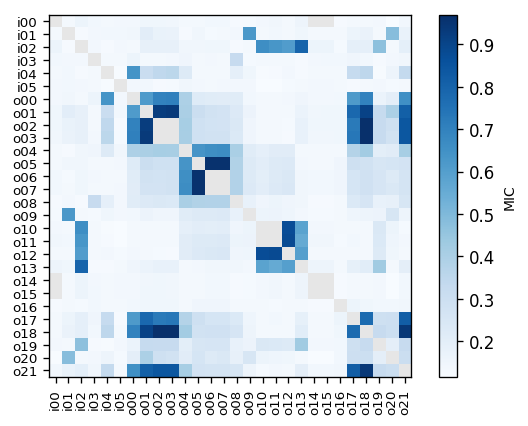

In [28]:
fig, ax = plt.subplots(1, 1)

cm = plt.cm.Blues
cm.set_bad((0,0,0,0.1))

ma = ax.imshow(mics_filter, cmap=cm)

ax.set_xticks(np.arange(28))
ax.set_yticks(np.arange(28))

ax.set_xticklabels([d for d in dat.columns], rotation=90, fontsize=8)
ax.set_yticklabels([d for d in dat.columns], fontsize=8)

fig.colorbar(ma, ax=ax, label='MIC')

## Time Resolved

Using something like MIC allows us to evaluate how the influence of an input parameter changes through time. For example, by calculating the MIC for a particular output as a function of all inputs for each time slice.

In [29]:
import os
import re
import minepy as mp
from tqdm import tqdm_notebook as tqdm

In [30]:
def mine_ouput(outpar, f, subset=None, miner_alpha=0.6, miner_c=20):
    """
    Calculate the MIC of an outut parameter as a function of all input parameters.
    
    Parameters
    ----------
    outpar : str
        Which output parameter to evaluate.
    f : str
        The path to the data file.
    subset : int
        If specified, uses a subset of the data (for speed).
    
    Returns
    -------
    
    """
    # load data
    inputs = ['i00','i01','i02','i03','i04','i05']
    outputs = ['o00','o01','o02','o03','o04','o05','o06',
               'o07','o08','o09','o10','o11','o12','o13',
               'o14','o15','o16','o17','o18','o19','o20',
               'o21']
    
    dat = pd.read_table(f, sep='\s+', header=None)
    dat.columns = inputs + outputs
    
    if isinstance(subset, int):
        dat = dat.sample(subset)


    # calculate MIC for output as fn of all inputs
    # create miner
    miner = mp.MINE(alpha=miner_alpha, c=miner_c)
    # create empty dict for outputs
    mics = {}
    
    # get response variable
    y = dat.loc[:, outpar].values
    # calculate MIC for all input vars
    for i in tqdm(inputs, leave=False):
        x = dat.loc[:, i].values
        if all(np.isnan(x)):
            mics[i] = np.nan    
        else:
            miner.compute_score(x, y)
            mics[i] = miner.mic()
    
    return mics

In [31]:
# get list of data files
fs = os.listdir('ModelData/')
fs = [f for f in fs if '.txt' in f]

#  regular expression (RegEx) for extracting the depth info from the file name
dex = re.compile('[0-9]+')

In [32]:
# calculate mics for all depth slices

outpar = 'o08'

depths = {}
for f in tqdm(fs):
    d = float(dex.match(f).group())
    
    depths[d] = mine_ouput(outpar, 'ModelData/' + f, subset=1000)

# convert outputs into a DataFrame
depths = pd.DataFrame(depths).T

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

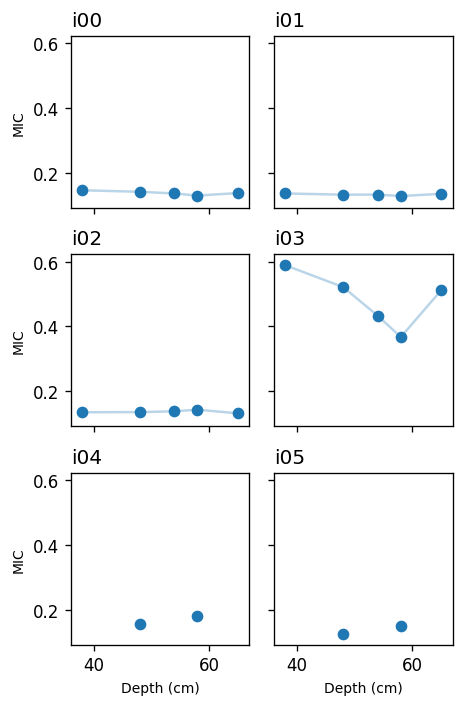

In [33]:
# plot them!
fig, axs = plt.subplots(depths.shape[1] // 2, 2, sharex=True, sharey=True, figsize=[4, 6])

for v, ax in zip(inputs, axs.flat):
    x = depths.index
    y = depths.loc[:, v]
    
    ax.plot(x, y, alpha=0.3)
    ax.scatter(x, y)
    
    ax.set_title(v, loc='left')
        
    if ax.is_first_col():
        ax.set_ylabel('MIC')
    if ax.is_last_row():
        ax.set_xlabel('Depth (cm)')


fig.tight_layout()

This shows how the MIC relating each input to a particular output changes with time.